In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sym 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
c=const.c.to("km/s")
%matplotlib inline
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885) 
# define cosmology on the basis of simulation

In [2]:
from astropy.table import Column, Table

path_2_data = 'halodir_044_0000.fit'
print('opening', path_2_data)
my_file=Table.read(path_2_data)
print(my_file.info()) #[1].data.columns)
data = my_file#[1].data

opening halodir_044_0000.fit
<Table length=121453>
        name         dtype       unit     
------------------- ------- --------------
              M200c float64               
              M500c float64               
               Macc float64               
              Mpeak float64               
        Mpeak_Scale float64               
               Mvir float64               
           Mvir_all float64               
          Rs_Klypin float64               
               Rvir float64               
               Spin float64               
       Spin_Bullock float64               
                T_U float64               
         Vmax_Mpeak float64               
               Voff float64               
              Vpeak float64               
               Xoff float64               
             b_to_a float64               
        b_to_a_500c float64               
             c_to_a float64               
        c_to_a_500c float64               
   

In [3]:
# Clusters ra , dec  and z
subhaloes = data.field('pid')>=0
z   = data.field('redshift_R')[subhaloes] # 
ra  = data.field('RA')        [subhaloes] #* (np.pi/180) # degrees
dec = data.field('DEC')       [subhaloes] # * (np.pi/180) # degrees
r_vir=data.field('Rvir') #"R_cl the virial radius of the cluster"
print(len(z), 'subhaloes')

18207 subhaloes


In [4]:
z.min(),z.max()

(0.21975586991888255, 0.27481521956993044)

In [5]:
D_cl=cosmos.comoving_distance(z)
d_C = D_cl
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian   - 180 ) * np.pi / 180.
    theta = (dec_radian + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

xx, yy, zz = get_x_y_z(ra, dec, dc_interpolation(z))


In [6]:
#Applying the mask"mask =np.where(data.RA<42.50)
sel_clusters = (data.field('M200c')>1e13 ) & ( data.field('M200c')<1e15) & (data.field('pid')==-1)
id_clusters = np.hstack(( np.argwhere( (data.field('M200c')>2e13 ) & ( data.field('M200c')<1e15) & (data.field('pid')==-1) ) ))
print(sel_clusters, len(sel_clusters.nonzero()[0]), id_clusters)
# Cluster ra and dec
#print(z_cl, r_cl)


[ True False False ... False False False] 134 [    0    64   126   155   196   218   250   269   297   314   332   344
   350   383   410   419   436   453   469   482   492   517   546   574
 48925 48952 48974 49018 49041 49049 49068 49079 49097 49106 49115 49141
 61415 61468 61495 61510 61531 61542 61554 61570 61578 61588 61597 61621
 75364 75400 75432 75480 75502 75517 75546 75602 75622 75627 75645 75656
 75668 75674 75685 75695]


In [7]:
# 
distances, angular_distances, id_galaxies, distinct_z, distinct_r = [], [], [], [], []

for id_cluster in np.arange(len(data))[sel_clusters]:
    
    # Getting the Halo parameters
    ra_cl=data.field('RA')[id_cluster]
    dec_cl=data.field('DEC')[id_cluster]
    z_cl=data.field('redshift_R')[id_cluster]
    r_cl= data.field('Rvir')[id_cluster]
    
    #Getting the cartesian position of the subhaloes with respect to the parent Halo 
    
    # Cartesian position of the Halo
    xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, dc_interpolation(z_cl))
    
    # Getting the distances of the subhaloes with respect to the Halo
    # DX= Distances
    DX = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2)
    
    # Setting the range within the virial Radii
    withinR = DX <= r_cl/1000.
    
    #Filtering the Subhaloes and distances within the Virial radii limit
    id_galaxies .append( np.arange(len(ra))[withinR] )
    distances .append( DX[withinR]/(r_cl/1000.) )
    
    # Projected Angular separation of the subhaloes and Halo
    coordinates_SubHaloes = SkyCoord( ra, dec, unit='deg', frame='icrs') 
    coordinate_cluster    = SkyCoord( ra_cl , dec_cl, unit='deg', frame='icrs') 
    
    #Computing the Separation in Degree
    Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
    
    #Separation in radian within the virial range of actual Distances
    Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)[withinR]
    
    angular_distances.append(Angular_separation_Astropy_radian) 
    
    #Distinct Z and r 
    distinct_z.append( z_cl*np.ones_like(Angular_separation_Astropy_radian).value )
    distinct_r.append( r_cl*np.ones_like(Angular_separation_Astropy_radian) )
    #print(distances)
distances = np.hstack(( distances ))
angular_distances = np.hstack(( angular_distances ))
id_galaxies = np.hstack(( id_galaxies ))
distinct_z = np.hstack(( distinct_z ))
distinct_r = np.hstack(( distinct_r ))
print(len(distances), id_galaxies)


3235 [    0     1     2 ... 16593 17116 17594]


In [8]:
RR=(angular_distances * cosmos.angular_diameter_distance(distinct_z)/u.radian).value


In [9]:
# Getting the projected separation of the subhaloes in Mpc
distinct_r = np.hstack(( distinct_r ))

#Distinct r = r/r_vir
r_3d = np.array(distances)/(distinct_r.value/1000.)
print(r_3d.min(), r_3d.max(), distinct_r.max().value/1000.)

#Projected distances of the subhaloes from the Halo centre in Mpc
r_proj = (angular_distances * cosmos.angular_diameter_distance(distinct_z)/u.radian  ).value * r_3d
print(r_proj, distances, r_proj< distances, distinct_r.value)

#Number of the subhaloes
N_subhaloes = len(r_proj)

0.0 2.0122094724074873 1.2586400000000002
[0.01938217 0.16394201 0.01649751 ... 0.18208516 0.69102584 0.11784357] [0.25123239 0.51518405 0.1659046  ... 0.56237285 0.98811609 0.74199751] [ True  True  True ...  True  True  True] [1163.62  1163.62  1163.62  ...  573.374  573.374  573.374]


In [10]:
distances.max(),r_proj.max(), r_3d.max(),RR.max()

(0.9997313711791157,
 0.8103210248547872,
 2.0122094724074873,
 1.0240305606477822)

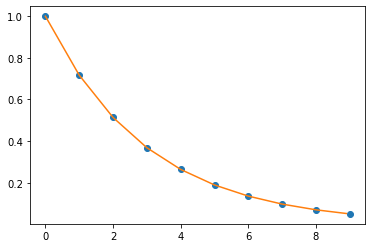

In [11]:
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [12]:
# Creating a histogram of distances in Mpc

# Creating a histogram of distances in Mpc

def get_bins(r_proj, N_per_bin=50):
    dR=0.0001
    
    #choosing the bins
    r_bins_fine = np.arange(0., 2., dR)
    
    # Projected distance
    N_2D_fine, bins_2D_fine = np.histogram(np.array(r_proj), bins = r_bins_fine)
    R_2D_fine = (bins_2D_fine[1:] + bins_2D_fine[:-1])/2.

    #rint( np.cumsum( N_2D_fine) )
    itp_bins = interp1d(np.cumsum( N_2D_fine), R_2D_fine )
    
    #rint(itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)))
    bins_2D = np.hstack((0., itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)), 2. ))
    #rint(bins_2D)
    
    return bins_2D
    # Three D distance
    #N_3D, bins_3D = np.histogram(np.array(distances[mask]), bins = r_bins)


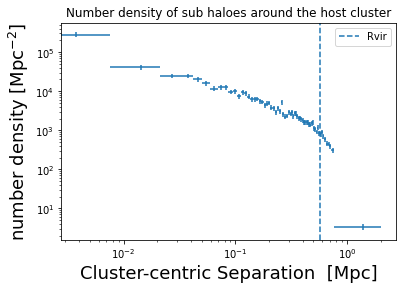

In [13]:
bins_2D = get_bins(r_proj, N_per_bin=50)

# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), bins = bins_2D)

#Getting the number density profile in 2D 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )

# central point of each separation 
dR_2D = [ bins_2D[1:] - R_2D, R_2D - bins_2D[:-1] ]

#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')
plt.yscale('log')
plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=r_cl/1000.,linestyle='dashed',label = 'Rvir')
plt.legend(loc=1, numpoints=1)
plt.show()

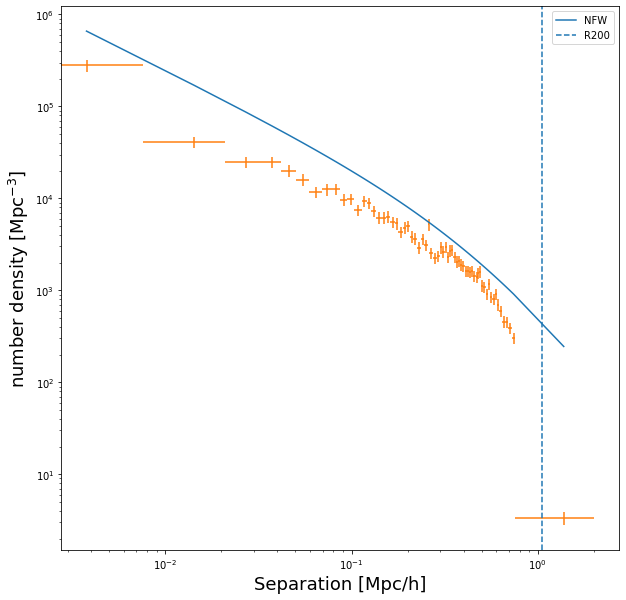

In [14]:
# Modelling with NFW profile 

from colossus.halo import profile_nfw
# Parameters
Rs=0.8
rhos = 3140
# Nfw as function of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

rho_nfw = p_nfw.density(R_2D)
# Plotting the function 
plt.figure(0, (10, 10))

# Modelling with NFW
plt.plot(R_2D,rho_nfw , label = 'NFW');
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')

# axis
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)

# r200
plt.axvline(x=1.059,linestyle='dashed',label = 'R200')

# Log scale
#plt.ylim((1e4, 1e8))
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1, numpoints=1)

In [15]:
r_proj.max()

0.8103210248547872

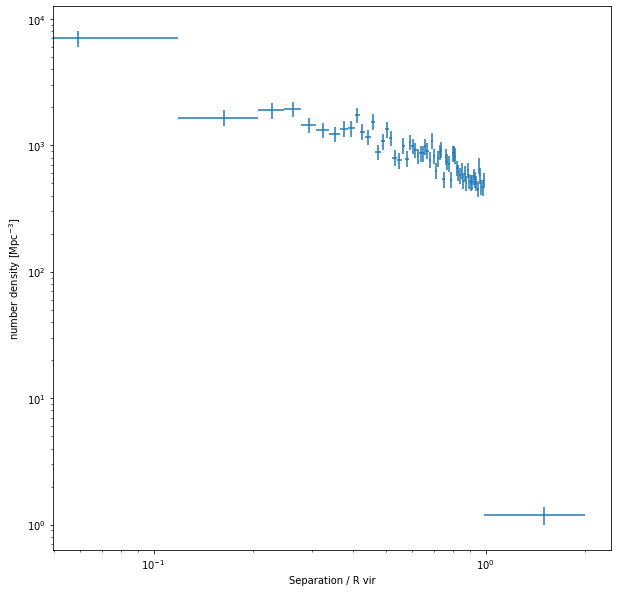

In [16]:
# Three D distance
bins_3D = get_bins(distances, N_per_bin=50)
N_3D, bins_3D = np.histogram(distances, bins = bins_3D)

R_3D = (bins_3D[1:] + bins_3D[:-1])/2.
dR_3D = [ bins_3D[1:] - R_3D, R_3D - bins_3D[:-1] ]

#Ns,rs=np.histogram(r)
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

r_act = (bins_3D[1:] + bins_3D[:-1])/2.
#plt.xscale('log')
#plt.yscale('log')
plt.figure(0, (10, 10))

plt.errorbar(r_act, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.plot(r_act, number_density, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation / R vir')
plt.ylabel(r'number density [Mpc$^{-3}$]')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [36]:
R_3D

array([0.059325  , 0.162825  , 0.227325  , 0.26275   , 0.29345   ,
       0.32345   , 0.351     , 0.3746    , 0.3944    , 0.41065   ,
       0.42595   , 0.44325   , 0.4583    , 0.4744    , 0.492     ,
       0.50545   , 0.5176    , 0.5327    , 0.5501    , 0.5649    ,
       0.5789    , 0.5921    , 0.602875  , 0.614025  , 0.6259    ,
       0.637725  , 0.648975  , 0.6591    , 0.66865   , 0.67905   ,
       0.68845   , 0.6974    , 0.7085    , 0.7194    , 0.72846667,
       0.73674167, 0.7473    , 0.758125  , 0.7669    , 0.77606667,
       0.78669167, 0.796325  , 0.8035    , 0.8107    , 0.8189    ,
       0.8281    , 0.83765   , 0.84695   , 0.8566    , 0.8662    ,
       0.8757125 , 0.8848625 , 0.8937    , 0.90325   , 0.9126    ,
       0.92145   , 0.929825  , 0.938475  , 0.947825  , 0.955825  ,
       0.962575  , 0.970775  , 0.9798    , 0.98815   , 1.496025  ])

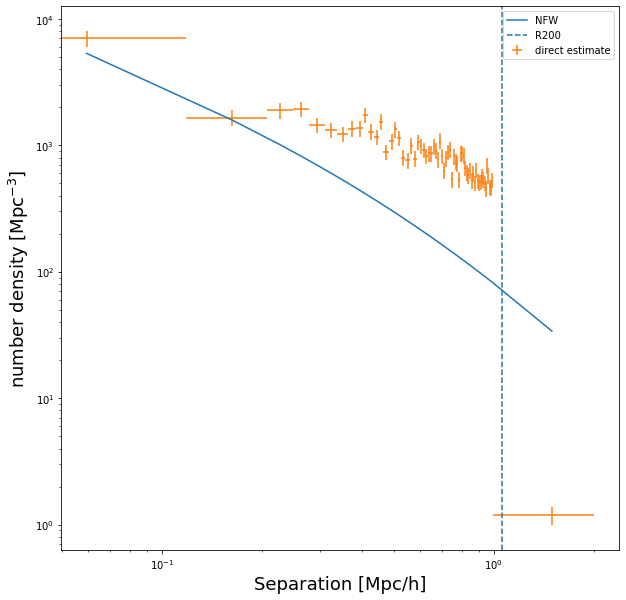

In [38]:
#  Modelling the nfw profile to the projected number density
from colossus.halo import profile_nfw
# Parameters
Rs=0.9
rhos =400.0
# Nfw as function of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

rho_nfwr = p_nfw.density(R_3D)
# Plotting the function 
plt.figure(0, (10, 10))

# Modelling with NFW
plt.plot(R_3D ,rho_nfwr , label = 'NFW');
plt.errorbar(r_act, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')

# axis
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)

# r200
plt.axvline(x=1.059,linestyle='dashed',label = 'R200')

# Log scale
#plt.ylim((1e2, 1e4))
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1, numpoints=1)

In [18]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R_2D, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/(np.pi))*(inter1(R_2D)/((R_2D**2 - r**2)**0.5))
        

    nu_all=[integrate.quad(nu, r_i,1.0, args=(r_i))[0] for r_i in R_3D ]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)



/tmp/ipykernel_32180/3123351499.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i,1.0, args=(r_i))[0] for r_i in R_3D ]
/tmp/ipykernel_32180/3123351499.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  nu_all=[integrate.quad(nu, r_i,1.0, args=(r_i))[0] for r_i in R_3D ]
/tmp/ipykernel_32180/3123351499.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  nu_all=[integrate.quad(nu, r_i,1.0, ar

In [19]:
nu_all

[73178.5191916465,
 14780.402511583889,
 3093.963925870462,
 14073.004532954066,
 705.3633832002354,
 3704.1926266320056,
 4865.371092939914,
 2765.372307541776,
 2571.5319980859767,
 1980.8741109994278,
 1570.3949227178377,
 1905.8825318759807,
 1604.6759959755716,
 1368.9912670215126,
 2626.9544658970112,
 2071.762455426069,
 1221.7382949796506,
 965.5896811447011,
 1499.2768589686295,
 1299.1415995575755,
 910.0695168788568,
 1179.8247621092892,
 1316.064359902864,
 1237.4751082750797,
 1011.4404058010963,
 863.1905518890319,
 756.7174419002095,
 681.6194096326583,
 629.3592460843453,
 598.5528783557558,
 612.002668101929,
 623.9826546448679,
 626.4860941161381,
 611.0855093964735,
 596.9932454966934,
 583.1402874404672,
 562.983655366049,
 541.8423855518887,
 524.8934465365768,
 507.35738076947814,
 487.23339104353863,
 469.16024007318765,
 455.79681357597013,
 442.4633847242741,
 427.3626329012149,
 410.51430099350523,
 393.1124462174249,
 376.23175322464203,
 358.76029217726824,


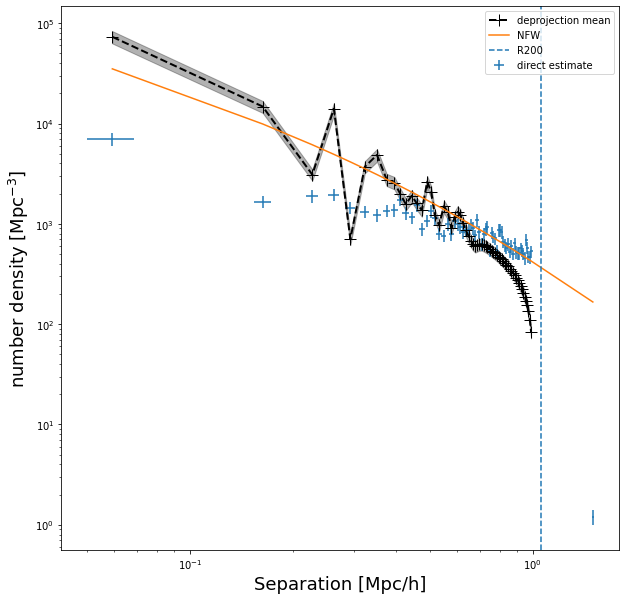

In [30]:
# plotting the de-projected number density wrt actual distance from the cluster center


# Nfw parameters modelling 
from colossus.halo import profile_nfw
# Parameters
Rs=0.7
rhos = 3500.0
# Nfw as 5unction of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

rho_nfw = p_nfw.density(R_3D)
# Plotting the function 
plt.figure(0, (10, 10))

# Plotting  the de-projected number density
plt.plot(R_3D , nu_all, label='deprojection mean', c='k',linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', markersize=12)
plt.fill_between(R_3D , y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')

# Direct estimate error bars / Actual density
plt.errorbar(r_act, number_density, xerr=0.01/1.059, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.errorbar(r_act, number_density*2*np.pi, xerr=0.01/1.059, ls='', yerr=number_density * N_3D**-0.5)

# Modelling with NFW
plt.plot(R_3D ,rho_nfw , label = 'NFW');
rho_nfw = p_nfw.density(R_3D )
# axis
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)

# r200
plt.axvline(x=1.059,linestyle='dashed',label = 'R200')

# Log scale
#plt.ylim((1e2, 1e6))
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1, numpoints=1)

In [21]:
distances.max(),r_proj.max(), r_3d.max(),RR.max()

(0.9997313711791157,
 0.8103210248547872,
 2.0122094724074873,
 1.0240305606477822)

In [22]:
np.sort(c*z)

<Quantity [65881.15240291, 65881.37375943, 65882.47472506, ...,
           82379.97849779, 82387.32067529, 82387.53017068] km / s>

In [23]:
c*z_cl

<Quantity 73222.28638283 km / s>

In [24]:
((c*z)-c*z_cl)/1+c*z

<Quantity [81121.9784524 , 81222.12504919, 81183.34180668, ...,
           59243.64498402, 58571.88116271, 59441.86331401] km / s>